In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Airbnb Data Playbook for Istanbul

This notebook is created to investigate some properties related to the Airbnb Istanbul data. This notebook is gonna be a living project with possibly adding new questions and trying to answer them.

**These are the questions that I'm gonna investigate in the near future:**
- Predict price for a new listing (listing is a record item)
- Check out the features affecting price the most
- The most popular neighborhoods (winter & summer, availability?)
- Neighborhoods getting the most reviews (up-to-date?)

**And, questions for the future:**
- Seasonal availability ratio for the listings/neighborhoods
- How positive is the reviewer?

## Data Preparation

Let's have a look at the columns and check whether we have informative values or not.

In [2]:
listings = pd.read_csv('istanbul/listings.csv', index_col='id')
print(listings.shape)
listings.head(3)

(19727, 105)


/usr/local/Cellar/ipython/7.5.0/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (43,61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4826,https://www.airbnb.com/rooms/4826,20190629051244,2019-06-29,The Place,My place is close to great views. My place is ...,A double bed apartment on the Asian side of Is...,My place is close to great views. My place is ...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/15347/ba87...,NaN,6603,https://www.airbnb.com/users/show/6603,Kaan,2009-01-14,"Istanbul, Istanbul, Turkey","Hello...\r\nI am Kaan and I am from Istanbul, ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/6603/profile_...,https://a0.muscache.com/im/users/6603/profile_...,Üsküdar,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Istanbul Province, Istanbul, Turkey",Üsküdar,Uskudar,NaN,Istanbul Province,Istanbul,34684,Istanbul,"Istanbul Province, Turkey",TR,Turkey,41.05650,29.05367,f,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Smoking ...",700.0,$607.00,NaN,NaN,NaN,NaN,2,$150.00,1,730,1,1,730,730,1.0,730.0,26 months ago,t,30,60,90,365,2019-06-29,1,0,2009-06-01,2009-06-01,100.0,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,flexible,f,f,1,1,0,0,0.01
20815,https://www.airbnb.com/rooms/20815,20190629051244,2019-06-29,The Bosphorus from The Comfy Hill,Watch The Bosphorus from The Comfy Hill. A spa...,"The low green hills of Arnavutköy, the lovely,...",Watch The Bosphorus from The Comfy Hill. A spa...,none,"The lovely neighborhood, Arnavutkoy, is locate...",The house may be suited with extra inflatable ...,"The city center, Taksim is about 6-7 kilometer...",Our dear guests may enjoy the oven and the was...,"Depending on our time available, we may even t...",- Windows facing the street should not be left...,NaN,NaN,https://a0.muscache.com/im/pictures/94805791/4...,NaN,78838,https://www.airbnb.com/users/show/78838,Gülder,2010-02-08,"Ankara, Ankara, Turkey",Başar Family\r\n\r\nGülder (mother): Owner of ...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/78838/profile...,https://a0.muscache.com/im/users/78838/profile...,Beşiktaş,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'wor...",t,f,"Istanbul, Turkey",Beşiktaş,Besiktas,NaN,Istanbul,NaN,34345,Istanbul,"Istanbul, Turkey",TR,Turkey,41.0698

In [3]:
nan_columns = listings.columns[listings.isnull().sum() / len(listings) > 0.8 ]
listings.drop(nan_columns,axis=1,inplace=True)
listings.shape

(19727, 95)

In [4]:
listings.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19727 entries, 4826 to 36183972
Data columns (total 95 columns):
listing_url                                     19727 non-null object
scrape_id                                       19727 non-null int64
last_scraped                                    19727 non-null object
name                                            19646 non-null object
summary                                         17389 non-null object
space                                           10779 non-null object
description                                     18240 non-null object
experiences_offered                             19727 non-null object
neighborhood_overview                           9133 non-null object
notes                                           4761 non-null object
transit                                         8526 non-null object
access                                          6925 non-null object
interaction                                     78

Seems like we have many object datatyped columns.  
We need to investigate these columns to understand whether they carry useful information or not.

In [5]:
objects = listings.columns[listings.dtypes == object]
print(objects)
listings[objects].head(1)

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'picture_url',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'smart_location', 'country_code', 'country',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'calendar_updated', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review',
       'requires_license', 'instant_bookable', 'is_business_travel_ready

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,price,security_deposit,cleaning_fee,extra_people,calendar_updated,has_availability,calendar_last_scraped,first_review,last_review,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4826,https://www.airbnb.com/rooms/4826,2019-06-29,The Place,My place is close to great views. My place is ...,A double bed apartment on the Asian side of Is...,My place is close to great views. My place is ...,none,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/15347/ba87...,https://www.airbnb.com/users/show/6603,Kaan,2009-01-14,"Istanbul, Istanbul, Turkey","Hello...\r\nI am Kaan and I am from Istanbul, ...",NaN,NaN,f,https://a0.muscache.com/im/users/6603/profile_...,https://a0.muscache.com/im/users/6603/profile_...,Üsküdar,"['email', 'phone', 'facebook', 'reviews']",t,f,"Istanbul Province, Istanbul, Turkey",Üsküdar,Uskudar,Istanbul Province,Istanbul,34684,Istanbul,"Istanbul Province, Turkey",TR,Turkey,f,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Smoking ...",$607.00,NaN,NaN,$150.00,26 months ago,t,2019-06-29,2009-06-01,2009-06-01,f,f,f,flexible,f,f


We can remove the columns that have same value for the entire dataset.  

In [6]:
same_valued_columns = ['is_business_travel_ready', 'country_code','country', 
                       'has_availability', 'calendar_last_scraped','requires_license',
                       'experiences_offered','last_scraped','require_guest_phone_verification',
                       'require_guest_profile_picture','host_has_profile_pic','scrape_id']
listings.drop(same_valued_columns,axis=1,inplace=True)


And, the columns that have inconsistent values.

In [7]:
inconsistent_valued_columns = ['city', 'state','street','neighbourhood']
listings.drop(inconsistent_valued_columns,axis=1,inplace=True)


In [8]:
listings.shape

(19727, 79)

In [9]:
removed_columns = same_valued_columns + inconsistent_valued_columns
objects = list(set(objects) - set(removed_columns))
objects

['amenities',
 'smart_location',
 'interaction',
 'summary',
 'host_response_rate',
 'market',
 'neighborhood_overview',
 'host_verifications',
 'transit',
 'instant_bookable',
 'is_location_exact',
 'description',
 'bed_type',
 'cleaning_fee',
 'host_name',
 'host_neighbourhood',
 'space',
 'last_review',
 'notes',
 'name',
 'listing_url',
 'room_type',
 'host_response_time',
 'host_is_superhost',
 'host_since',
 'access',
 'extra_people',
 'host_url',
 'calendar_updated',
 'host_identity_verified',
 'host_location',
 'house_rules',
 'host_picture_url',
 'host_thumbnail_url',
 'price',
 'zipcode',
 'picture_url',
 'host_about',
 'property_type',
 'first_review',
 'security_deposit',
 'neighbourhood_cleansed',
 'cancellation_policy']

From the above list we can see that there are some columns with wrong datatype like price which should have numerical datatype.

Some of them doesn't seem useful at all like urls, so we can just drop them. And, some of them might be useful like notes and transit explanation that people might find necessary info in these parts that affects their decisions. But, for simplicity we can drop them as well.

Some columns definitely need extra analysis and processing.
 

In [10]:
wrong_datatyped = ['cleaning_fee','security_deposit','price','extra_people']
not_useful_columns = ['host_thumbnail_url','picture_url','host_picture_url','host_url','listing_url','market','host_id']
maybe_useful_columns = ['host_about', 'house_rules', 'summary', 'description', 'name', 'notes', 'transit', 'neighborhood_overview', 'host_name', 'interaction', 'zipcode', 'space', 'host_location', 'access', 'smart_location', 'host_neighbourhood']
boolean_columns = ['host_identity_verified', 'is_location_exact', 'instant_bookable', 'host_is_superhost']
extra_processing = ['host_response_rate', 'property_type', 'calendar_updated', 'host_verifications', 'neighbourhood_cleansed', 'amenities', 'room_type', 'cancellation_policy', 'host_response_time', 'bed_type', 'last_review','host_since','first_review']


In [11]:
listings.drop(not_useful_columns,axis=1,inplace=True)
listings.drop(maybe_useful_columns,axis=1,inplace=True)


We can leave `wrong_datatyped` columns for now since these should be numerical columns and we can deal with numerical processing later.

We can convert `boolean_columns` to numerical columns.

In [12]:
for column in boolean_columns:
    listings[column] = listings[column].apply(lambda x: 1 if x == 't' else 0)

And, start investigating `extra_processing` columns.

`host_response_rate` might be an important feature, values are like 93% in the dataset. We can convert these values to float ones by dividing 10 to put them into relevant buckets 0-10. 


In [13]:
listings.host_response_rate = [x if pd.isna(x) else int(x / 10) for x in [x if pd.isna(x) else int(x[:-1]) for x in listings.host_response_rate]]


In [14]:
listings.property_type.value_counts(normalize=True)

Apartment                 0.607391
Serviced apartment        0.111725
House                     0.054443
Boutique hotel            0.042987
Bed and breakfast         0.042125
Aparthotel                0.023268
Condominium               0.021341
Townhouse                 0.020023
Hotel                     0.018249
Loft                      0.017286
Villa                     0.011862
Hostel                    0.008212
Casa particular (Cuba)    0.006184
Other                     0.004512
Guesthouse                0.001571
Tiny house                0.001369
Guest suite               0.001014
Earth house               0.000760
Farm stay                 0.000659
Cottage                   0.000558
Boat                      0.000558
Nature lodge              0.000558
Treehouse                 0.000406
Yurt                      0.000406
Castle                    0.000355
Lighthouse                0.000304
Camper/RV                 0.000253
Bungalow                  0.000253
Chalet              

`property_type` carries very granular types, we can keep the most occuring one and merge the rest to the `other` type.


In [15]:
property_types = ['Apartment']

listings.loc[~listings.property_type.isin(property_types), 'property_type'] = 'Other'

In [16]:
listings.calendar_updated.value_counts()[:10]

today           2507
2 weeks ago     1225
2 months ago    1193
a week ago       973
3 months ago     820
3 weeks ago      763
yesterday        752
4 months ago     613
never            599
4 weeks ago      579
Name: calendar_updated, dtype: int64

`calendar_updated` has 102 different values, and I'm not sure if this column actually affects people's decision. For simplicity, I'll drop it.

Same goes for `host_verifications`, it has 274 different values as array type having different string values in it.

In [17]:
listings.drop('calendar_updated',axis=1,inplace=True)
listings.drop('host_verifications',axis=1,inplace=True)

In [19]:
listings.neighbourhood_cleansed.value_counts(normalize=True)

Beyoglu          0.264713
Sisli            0.143053
Fatih            0.130278
Kadikoy          0.103259
Besiktas         0.082679
Uskudar          0.035636
Esenyurt         0.024180
Kagithane        0.023622
Sariyer          0.017134
Atasehir         0.015816
Maltepe          0.015106
Bakirkoy         0.013129
Bahcelievler     0.010493
Basaksehir       0.010341
Umraniye         0.008871
Adalar           0.008770
Eyup             0.008719
Pendik           0.008466
Kartal           0.007553
Avcilar          0.007502
Kucukcekmece     0.007452
Bagcilar         0.006438
Buyukcekmece     0.005475
Zeytinburnu      0.005120
Beykoz           0.005120
Sile             0.004917
Beylikduzu       0.004207
Tuzla            0.003548
Gaziosmanpasa    0.003498
Gungoren         0.003244
Cekmekoy         0.002332
Silivri          0.002078
Sancaktepe       0.001774
Bayrampasa       0.001115
Arnavutkoy       0.001065
Sultangazi       0.000963
Sultanbeyli      0.000963
Esenler          0.000963
Catalca     

I think `neighbourhood_cleansed` should have an important affect to people's decision, I'm gonna keep it as it is.

`amenities` carries useful information as string arrays. We need to extract the values into separate columns.

In [20]:
# find unique amenities in the whole dataset
amenities = set()
unique_amenities = listings.amenities.unique()

for item in unique_amenities:
    items = item[1:-1].replace('"','').split(',')
    for x in items:
        if x:
            amenities.add(x.strip())

# convert them into separate columns
for item in amenities:
    listings.loc[listings['amenities'].str.contains(item), item] = 1

/usr/local/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


After extracting values into columns, we have many columns carrying more than 80% NaN values. We'll clean them first and then drop original `amenities` column.

In [21]:
nan_columns = listings.columns[listings.isnull().sum() / len(listings) > 0.8 ]
listings.drop(nan_columns,axis=1,inplace=True)

listings.drop('amenities',axis=1,inplace=True)

In [22]:
amenities_columns = ['Luggage dropoff allowed','Carbon monoxide detector', 'Washer', 'Bed linens', 'Cable TV','Laptop friendly workspace', 'Fire extinguisher', 'First aid kit','Kitchen', 'Refrigerator', 'Pets allowed', 'Long term stays allowed','Smoke detector', 'Host greets you', 'Hot water', 'TV', 'Hair dryer','Heating', 'Family/kid friendly', 'Free parking on premises', 'Shampoo','Essentials', 'Smoking allowed', 'Lock on bedroom door', 'Dryer','Air conditioning', 'Breakfast', 'Internet', 'Cooking basics', 'Iron','Wifi', 'Elevator', 'Hangers']
listings[amenities_columns] = listings[amenities_columns].fillna(0)

In [23]:
listings.shape

(19727, 86)

In [24]:
listings.room_type.value_counts()

Private room       9780
Entire home/apt    9386
Shared room         561
Name: room_type, dtype: int64

These values seem ok top keep `room_type` column as it is.

Same for `cancellation_policy` and `host_response_time`, I'll keep them.

In [26]:
listings.bed_type.value_counts()

Real Bed         19518
Pull-out Sofa      129
Couch               60
Airbed              12
Futon                8
Name: bed_type, dtype: int64

In [28]:
listings.drop('bed_type',axis=1,inplace=True)

And, the rest are related to the date columns: `'last_review','host_since','first_review'`. We can convert these columns into numerical values to specify how many days passed till the date which the dataset had been generated.

In [29]:
date_columns = ['last_review','host_since','first_review']

for column in date_columns:
    listings[column] = pd.to_datetime(listings[column])
    listings[column + '_diff'] = (datetime(2019, 6, 29) - listings[column]).astype('timedelta64[D]')

listings.drop(date_columns, axis=1, inplace=True)

In [30]:
listings.columns[listings.dtypes == 'object']

Index(['host_response_time', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'cancellation_policy'],
      dtype='object')

From the above list, we can see that we've cleaned the object data typed columns mostly. Now we can deal with `wrong_datatyped` columns. These are all price columns, so we need to convert them into numerical data types.

In [31]:
for column in wrong_datatyped:
    listings[column] = [x if pd.isna(x) else int(x.replace(',','')) for x in [x if pd.isna(x) else x[1:-3] for x in listings[column]]]
    

In [32]:
listings.columns[listings.dtypes != 'object']

Index(['host_response_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_identity_verified', 'latitude',
       'longitude', 'is_location_exact', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',

Some of the numerical columns look suspicious as they can carry the same data as a group.
Now, I'm gonna investigate these columns.

In [33]:
listings_count = ['host_listings_count', 'host_total_listings_count','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms']
min_max_nights = ['minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights','maximum_maximum_nights', 'minimum_nights_avg_ntm','maximum_nights_avg_ntm']
availabilities = ['availability_30', 'availability_60','availability_90', 'availability_365']
reviews = ['number_of_reviews','number_of_reviews_ltm', 'reviews_per_month']


In [34]:
len(listings[listings.host_listings_count != listings.host_total_listings_count])

27

Yep, seems like these columns carry the same info.

And, if we can sum the values of `'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
'calculated_host_listings_count_shared_rooms'` we can get `'calculated_host_listings_count'`. So no need to keep at granular level.  



In [35]:
len(listings[listings.host_listings_count !=  (listings.calculated_host_listings_count_entire_homes + listings.calculated_host_listings_count_private_rooms + listings.calculated_host_listings_count_shared_rooms)])


2705

In [36]:
listings_count.remove('host_listings_count')
listings.drop(listings_count, axis=1, inplace=True)


In [37]:
print(len(listings[listings.minimum_nights != listings.minimum_minimum_nights]))
print(len(listings[listings.minimum_nights != listings.minimum_maximum_nights]))
print(len(listings[listings.minimum_nights != listings.minimum_nights_avg_ntm]))
print(len(listings[listings.maximum_nights != listings.maximum_minimum_nights]))
print(len(listings[listings.maximum_nights != listings.maximum_maximum_nights]))
print(len(listings[listings.maximum_nights != listings.maximum_nights_avg_ntm]))


370
19600
870
19569
23
32


In [38]:
listings[listings.minimum_nights != listings.minimum_maximum_nights][['minimum_nights','minimum_maximum_nights']][:5]

,minimum_nights,minimum_maximum_nights
id,,
4826,1,730
20815,30,210
25436,21,1125
27271,20,60
28277,3,360


In [39]:
listings[listings.maximum_nights != listings.maximum_minimum_nights][['maximum_nights','maximum_minimum_nights']][:5]

,maximum_nights,maximum_minimum_nights
id,,
4826,730,1
20815,210,30
25436,1125,21
27271,60,20
28277,360,3


We can definitely remove `'minimum_minimum_nights','minimum_nights_avg_ntm','maximum_maximum_nights','maximum_nights_avg_ntm'`.

I'm not sure if we need to keep `'minimum_maximum_nights','maximum_minimum_nights'` but I'm gonna keep them.

In [40]:
listings.drop(['minimum_minimum_nights','minimum_nights_avg_ntm','maximum_maximum_nights','maximum_nights_avg_ntm'],axis=1,inplace=True)


`availabilities` group shows the availability of a listing within 30, 60, 90 and 365 days.  
`reviews` shows total number of reviews, the number of reviews in the last twelve months and per month review counts.  
These might be important, I'm gonna keep them.

In [41]:
listings.shape

(19727, 76)

In [42]:
items = listings.copy()

Now, we can investigate numerical columns thoroughly. Let's start filling na values.

In [43]:
items.columns[items.isnull().sum() > 0]

Index(['host_response_time', 'host_response_rate', 'host_listings_count',
       'bathrooms', 'bedrooms', 'beds', 'security_deposit', 'cleaning_fee',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'cancellation_policy', 'reviews_per_month',
       'last_review_diff', 'host_since_diff', 'first_review_diff'],
      dtype='object')

For price columns, if they are null probably they should have 0 values.

In [44]:
items[['security_deposit', 'cleaning_fee']] = items[['security_deposit', 'cleaning_fee']].fillna(0)        
        

In [45]:
numerical_columns = items.columns[items.dtypes != 'object']
for column in numerical_columns:
    median_value=items[column].median()
    items[column]=items[column].fillna(median_value)

In [46]:
numericals = set(numerical_columns) - set(amenities_columns)
items[numericals].describe()

,host_since_diff,instant_bookable,host_response_rate,bedrooms,is_location_exact,cleaning_fee,guests_included,minimum_nights,review_scores_accuracy,maximum_nights,longitude,latitude,review_scores_communication,review_scores_location,minimum_maximum_nights,host_is_superhost,accommodates,last_review_diff,availability_90,availability_365,bathrooms,reviews_per_month,extra_people,first_review_diff,host_identity_verified,availability_30,review_scores_cleanliness,number_of_reviews_ltm,review_scores_rating,price,number_of_reviews,host_listings_count,maximum_minimum_nights,availability_60,security_deposit,beds,review_scores_value,review_scores_checkin
count,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,1.972700e+04,19727.000000,19727.000000,19727.000000,19727.000000,1.972700e+04,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.000000,19727.00000,19727.000000,19727.000000
mean,1126.430375,0.561768,9.052162,1.355908,0.315253,45.284635,1.392508,4.335885,9.669032,1.098158e+05,28.984211,41.027520,9.795407,9.741218,1.098156e+05,0.076393,3.105084,136.037005,68.214376,243.167942,1.192579,0.788288,28.110407,457.802859,0.190298,20.411872,9.579713,3.631520,93.845440,377.366706,7.257616,14.309576,4.593501,43.538754,231.105338,2.02489,9.632281,9.783444
std,817.006423,0.496183,2.367778,1.406741,0.464628,108.414052,1.097863,26.246753,1.024591,1.528971e+07,0.118671,0.043559,0.858788,0.847667,1.528971e+07,0.265632,2.222619,276.277165,31.058530,135.189250,0.897655,0.863115,61.834418,465.711174,0.392546,11.691232,1.100828,9.969259,9.685367,1291.115797,22.274279,108.425903,28.135452,21.897423,1273.113740,2.06572,1.025097,0.873845
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000e+00,28.032000,40.813280,2.000000,2.000000,1.000000e+00,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,20.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,2.000000,2.000000
25%,335.000000,0.000000,10.000000,1.000000,0.000000,0.000000,1.000000,1.000000,10.000000,6.000000e+01,28.973640,41.004830,10.000000,10.000000,6.000000e+01,0.000000,2.000000,58.000000,56.000000,99.000000,1.000000,0.570000,0.000000,326.000000,0.000000,10.000000,10.000000,0.000000,96.000000,116.000000,0.000000,1.000000,1.000000,29.000000,0.000000,1.00000,10.000000,10.000000
50%,1131.000000,1.000000,10.000000,1.000000,0.000000,0.000000,1.000000,1.000000,10.000000,1.125000e+03,28.984040,41.031740,10.000000,10.000000,1.125000e+03,0.000000,2.000000,58.000000,87.000000,324.000000,1.000000,0.570000,0.000000,326.000000,0.000000,28.000000,10.000000,0.000000,96.000000,208.000000,0.000000,2.000000,1.000000,57.000000,0.000000,1.00000,10.000000,10.000000
75%,1737.000000,1.000000,10.000000,2.000000,1.000000,50.000000,1.000000,2.000000,10.000000,1.125000e+03,29.021575,41.047980,10.000000,10.000000,1.125000e+03,0.000000,4.000000,58.000000,90.000000,364.000000,1.000000,0.570000,45.000000,326.000000,0.000000,30.000000,10.000000,2.000000,96.000000,381.000000,4.000000,5.000000,2.000000,60.000000,0.000000,2.00000,10.000000,10.000000
max,3818.000000,1.000000,10.000000,50.000000,1.000000,3500.000000,16.000000,1000.000000,10.000000,2.147484e+09,29.907780,41.414420,10.000000,10.000000,2.147484e+09,1.000000,16.000000,3680.000000,90.000000,365.000000,45.000000,10.000000,1700.000000,3680.000000,1.000000,30.000000,10.000000,613.000000,100.000000,65726.000000,658.000000,1237.000000,1100.000000,60.000000,29897.000000,50.00000,10.000000,10.000000


Some columns have outlier values or their distributions might be skewed like `price` and `security_deposit`.  
Let's look at the `price` column since it is also our target variable.


In [47]:
items['price'].describe()

count    19727.000000
mean       377.366706
std       1291.115797
min          0.000000
25%        116.000000
50%        208.000000
75%        381.000000
max      65726.000000
Name: price, dtype: float64

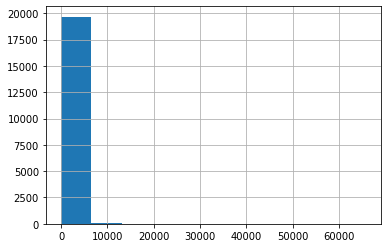

In [48]:
items['price'].hist()

We have outlier values for `price` column, so we can remove these rows.

In [50]:
len(items[items['price'] > 10000]) / items.shape[0]

0.0015714502965478785

In [51]:
# items = items[items['price'] <= 1000]
items.loc[items.price >= 10000, 'price'] = 10000

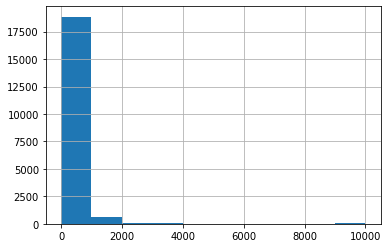

In [52]:
items['price'].hist()

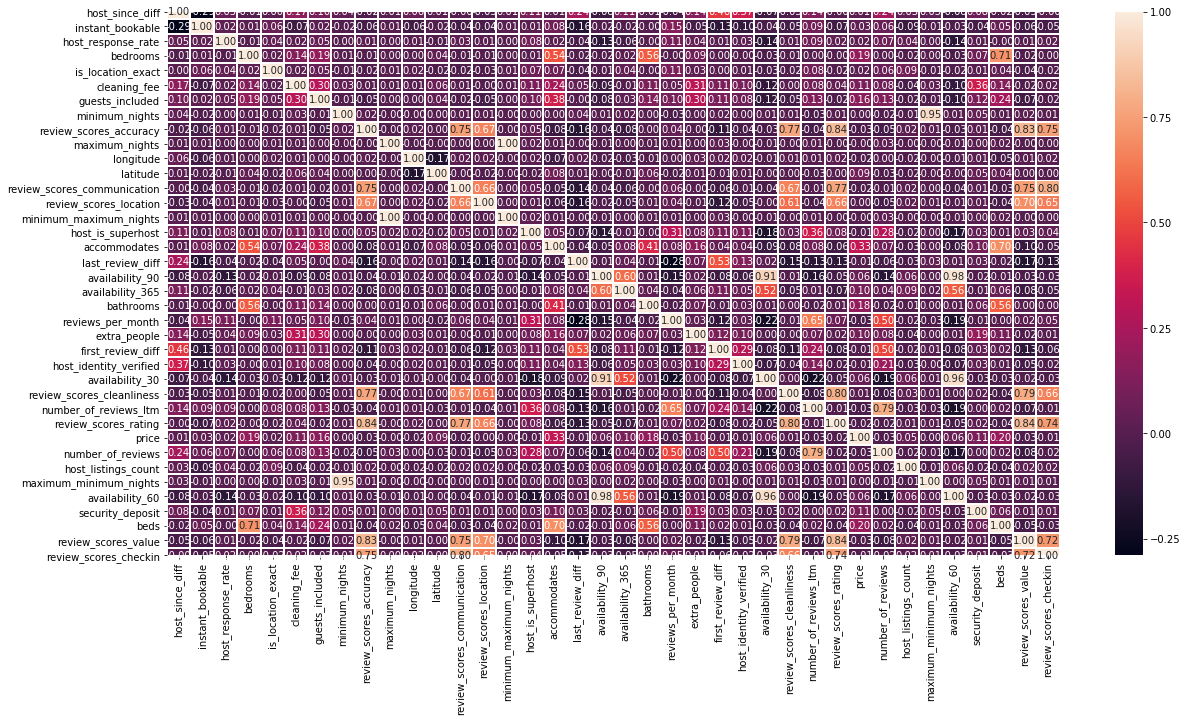

In [53]:
plt.figure(figsize = (20,10))
sns.heatmap(items[numericals].corr(), annot=True, fmt='.2f', linewidths=.8) 

availability_60 => availability_90, availability_30

review_scores_value => review_scores_rating, review_scores_accuracy

maximum_nights => maximum_mininum_nights

minimum_nights => maximum_mininum_nights

mininum_maximum_nights => maximum_nights

In [54]:
drop_cols = ['availability_60','availability_90','number_of_reviews_ltm','review_scores_cleanliness','review_scores_communication','review_scores_rating','review_scores_accuracy','maximum_minimum_nights','minimum_maximum_nights'] 
items.drop(drop_cols,axis=1,inplace=True)

numericals = set(numericals) - set(drop_cols)


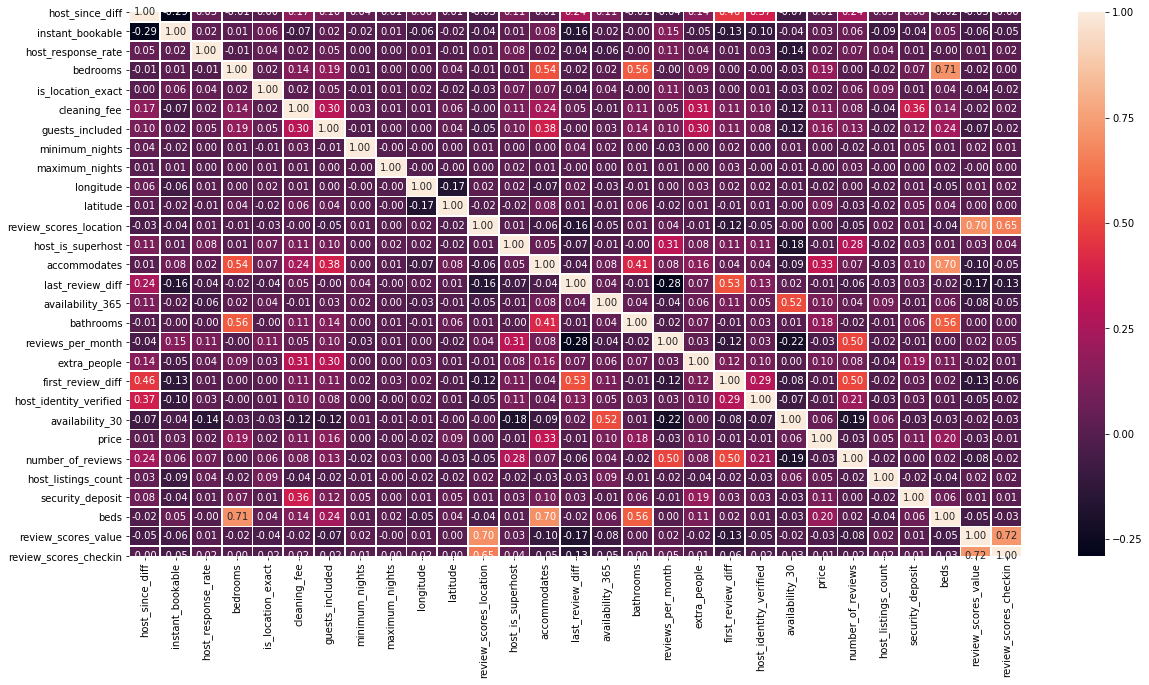

In [55]:
plt.figure(figsize = (20,10))
sns.heatmap(items[numericals].corr(), annot=True, fmt='.2f', linewidths=.8) 

In [56]:
processes_items = items.copy()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12dff3a90>,
      dtype=object)

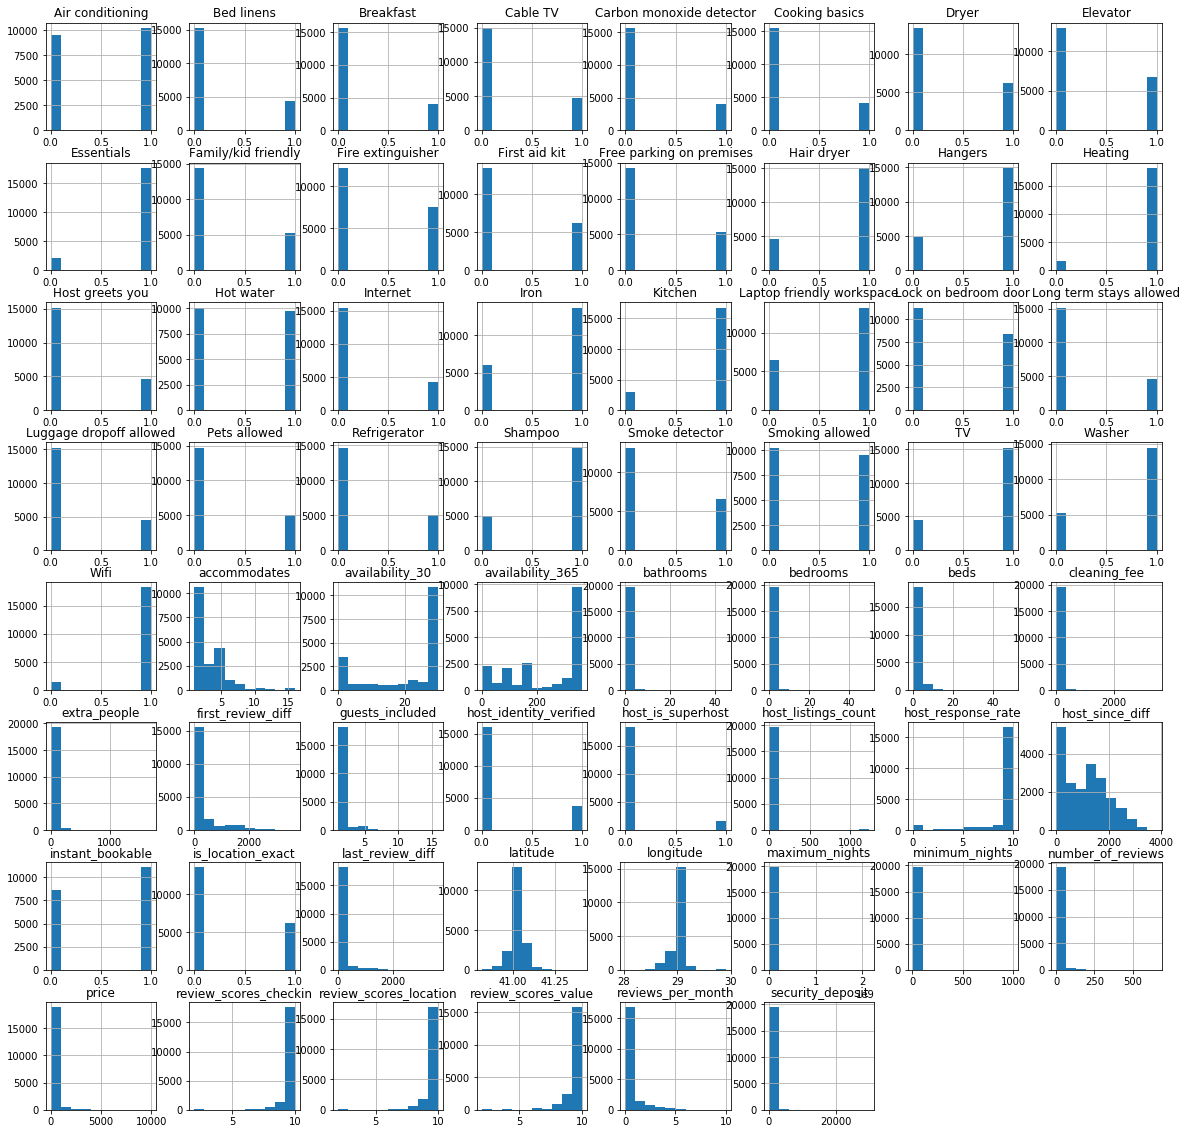

In [57]:
processes_items.hist(figsize=(20,20))

Some of the columns have mostly the same value, we should remove them.

In [61]:
drop_num_cols = ['review_scores_value','review_scores_location','review_scores_checkin','bathrooms','host_identity_verified','host_is_superhost']

processes_items.drop('Heating',axis=1,inplace=True)
processes_items.drop('Kitchen',axis=1,inplace=True)
processes_items.drop('Essentials',axis=1,inplace=True)
processes_items.drop('Wifi',axis=1,inplace=True)
processes_items.drop(drop_num_cols,axis=1,inplace=True)

numericals = set(numericals) - set(drop_num_cols)


In [62]:
drop_num_cols = ['latitude','longitude','availability_365'] 

processes_items.drop(drop_num_cols,axis=1,inplace=True)

numericals = set(numericals) - set(drop_num_cols)
    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1383a09e8>,
      dtype=object)

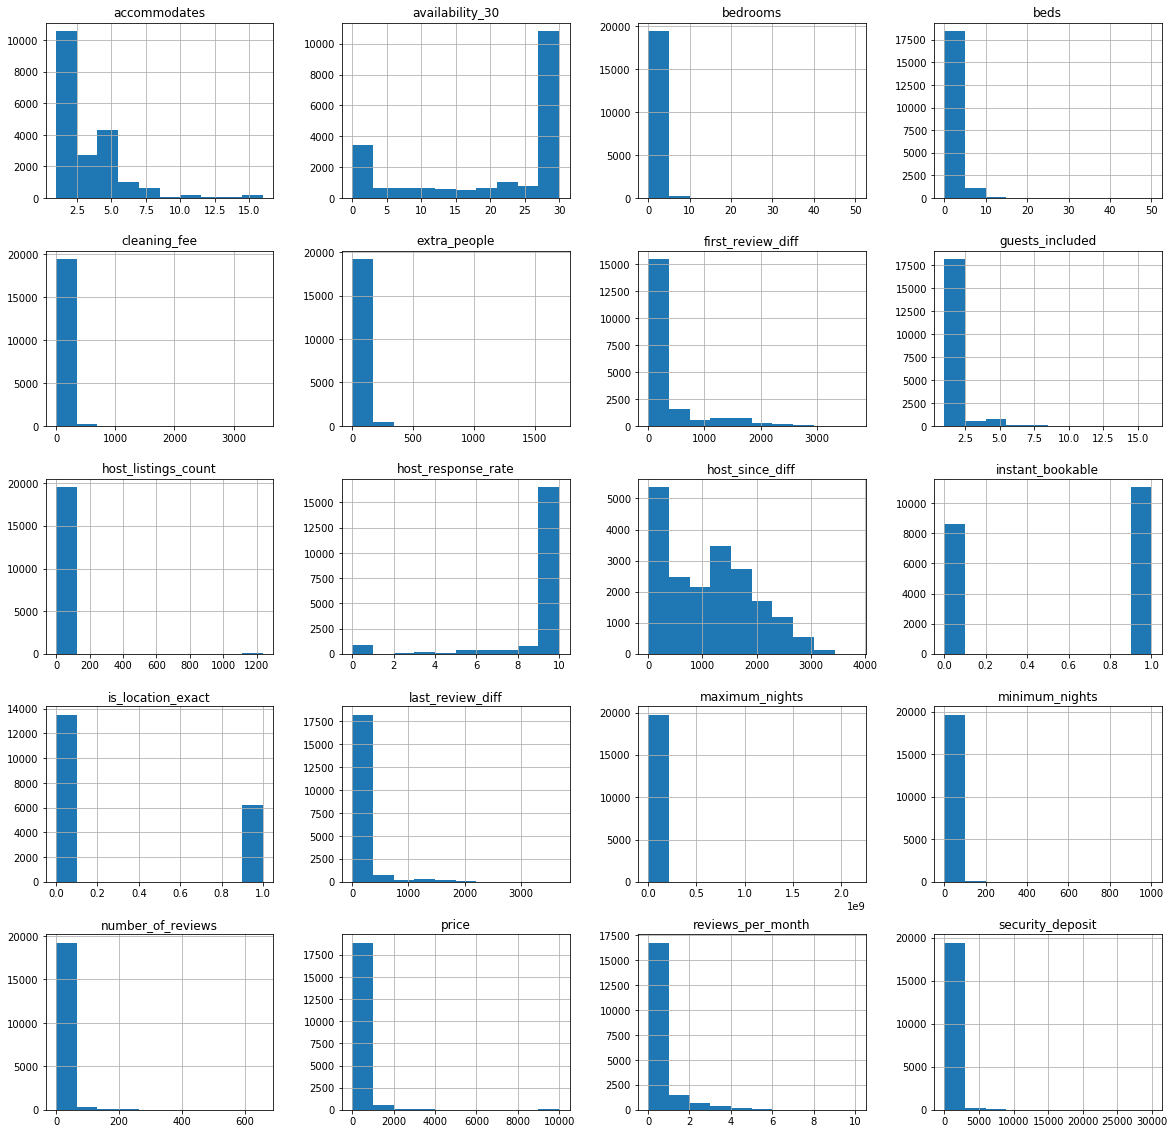

In [63]:
processes_items[numericals].hist(figsize=(20,20))

The columns except `'accommodates','availability_30','host_since_diff'` have skewed distributions. Log transformation might be useful for them.

In [64]:
log_columns = set(numericals) - set(['accommodates','availability_30', 'host_since_diff'])

for column in log_columns:
    processes_items[column] = processes_items[column].astype('float64').replace(0.0, 0.01)
    processes_items[column] = np.log(processes_items[column])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a700390>,
      dtype=object)

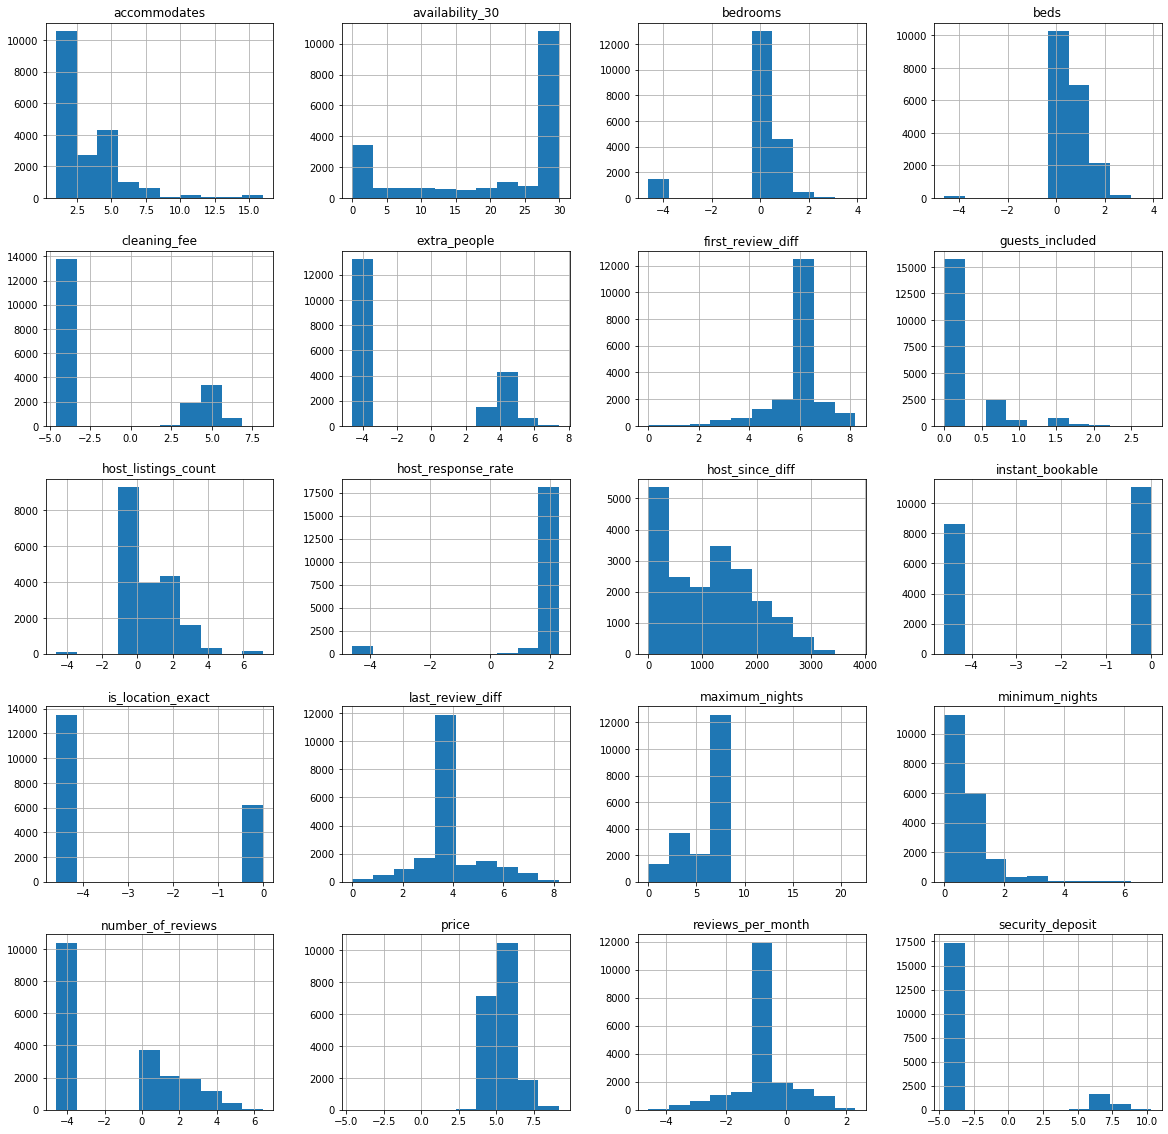

In [65]:
processes_items[numericals].hist(figsize=(20,20))

### ML

For multi categorical columns, get_dummies method can handle most of them to convert them into the numerical values, but for some of them manual analysis and extraction should be made. See below operations.

In [66]:
features = processes_items.drop('price',axis=1)
y = items['price']

In [67]:
scaler = StandardScaler()
numerical_columns = features.columns[features.dtypes != 'object']
features[numerical_columns] = scaler.fit_transform(features[numerical_columns])

In [68]:
dummied_items = pd.get_dummies(features,dummy_na=True)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(dummied_items,y,test_size=0.30,random_state=0)

In [73]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
linear_regression.score(X_train,y_train)

0.1943714495518265

In [72]:
kn = KNeighborsRegressor()
kn.fit(X_train, y_train)
kn.score(X_train, y_train)

0.5385382553433744

In [71]:
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)
gbr.score(X_train, y_train)

0.4257095487330972

In [82]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show() 

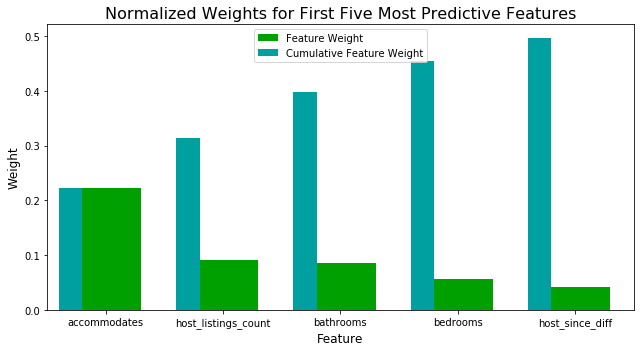

In [83]:
importances = gbr.feature_importances_
feature_plot(importances, X_train, y_train)

In [74]:
tree = DecisionTreeRegressor(random_state=0)
tree.fit(X_train, y_train)
tree.score(X_train, y_train)

0.9960104529129801

In [75]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_reg.score(X_train, y_train)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:07:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.4033527001826791

knn or gradient boosting seems to produce meaningful results. Desicion tree is probably overfitting. To improve this, we need to complete feature preprocessing thoroughly and maybe try tunning hyperparameters for the algorithm.

TBC